# Setup

In [14]:
import os

import numpy as np
import matplotlib.pyplot as plt
import h5py

from slab.instruments import InstrumentManager
from slab.dsfit import *

%matplotlib notebook

In [17]:
# Connect to MXG

im = InstrumentManager(config_path="C:\_Lib\python\slab\instruments\instruments.cfg")
mxg1 = im['MXG1']
mxg2 = im['MXG2']

print(mxg1.get_id())
print(mxg2.get_id())

# Connect to QICK

import qick 

import Pyro4
from qick import QickConfig
Pyro4.config.SERIALIZER = "pickle"
Pyro4.config.PICKLE_PROTOCOL_VERSION=4

ns_host = '192.168.0.133'  #ip of client pc where the nameserver is running
ns_port = 8000
server_name = "myqick"

ns = Pyro4.locateNS(host=ns_host, port=ns_port)

# Import the QICK drivers and auxiliary libraries

from qick import *
from tqdm.notebook import tqdm

soc = Pyro4.Proxy(ns.lookup(server_name))
soccfg = QickConfig(soc.get_cfg())
print(soccfg)  

Loaded Instruments:  

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

# Resonator Spectroscopy

In [3]:
from CL_multimode_experiments.resonator_spectroscopy import *
import importlib

# Configure LO

mxg1.set_output(state=False)
mxg1.set_frequency(7000000000)
mxg1.set_power(19)

data_path = "C:\\_Lib\\python\\Qick Old meas lab\\Test ZCU216 experiments\\"
filename = 'res_spec'

In [4]:
path_to_parent = r'C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments' # this is where the parent folder lives (to get location of config file)
rspec = ResonatorSpectroscopyExperiment(path=path_to_parent,config_file='config_new.json')
rspec.cfg.expt={"start":282.64250503817-20, "step":.1 , "expts": 500, "reps":10000}

C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 2000, 'freq': 283.522897861389, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 283.522897861389, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.440389397353, 'f_ef': 4096.949181331015, 'pulses': {'pi_ge': {'gain': 2400, 'sigma': 0.2303}, 'pi2_ge': {'gain': 2400, 'sigma': 0.1152}}}}}, 'aliases': {'soc': 'myqick'}, 'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.236037836558, 'f_ef': 4100.0, 'pulses': {'pi

In [5]:
mxg1.set_output(state=True)
rspec.acquire(data_path=data_path, filename=filename, progress=True)
mxg1.set_output(state=False)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\Chakram_Meas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\Chakram_Meas\AppData\Local\Temp\ipykernel_10208\1833117314.py", line 2, in <module>
    rspec.acquire(data_path=data_path, filename=filename)
  File "C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\CL_multimode_experiments\resonator_spectroscopy.py", line 184, in acquire
    avgi,avgq=self.prog.acquire(self.im[self.cfg.aliases.soc], load_pulses=True, progress=False)
  File "c:\_lib\python\qick\qick_lib\qick\averager_program.py", line 106, in acquire
    d_buf, avg_d, shots = super().acquire(soc, reads_per_rep=readouts_per_experiment, load_pulses=load_pulses, start_src=start_src, progress=progress, debug=debug)
  File "c:\_lib\python\qick\qick_lib\qick\qick_asm.py", line 1172, in acquire
    new_data = obtain(soc.poll_data())
  File "C:\Users\Chakram_Meas\anac

TypeError: object of type 'NoneType' has no len()

<IPython.core.display.Javascript object>


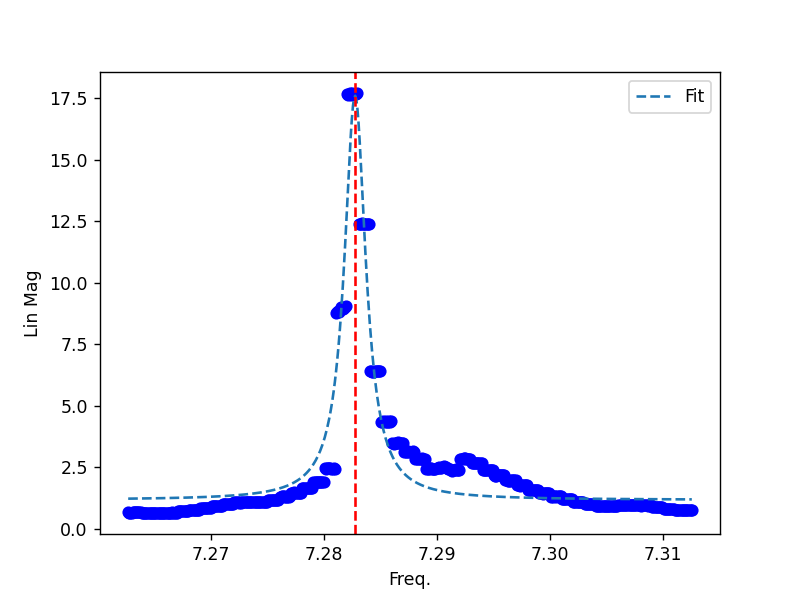

Resonator Frequency: 7.282728267532144


In [13]:
result_dict = h5py.File('C:\\_Lib\\python\\Qick Old meas lab\\Test ZCU216 experiments\\00018_res_spec.h5', 'r')
f0 = 7
freq = result_dict['freq'][0]/1e3+f0
lin_mag = np.sqrt(result_dict['avgq'][0]**2 + result_dict['avgi'][0]**2)
# log_mag = np.array(file['mags'])[0]
# phase = np.array(file['phases'])[0]
# read_power = np.array(file['read_power'])[0]

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq, lin_mag,'bo')

p = fitlor(freq, lin_mag)
ax.plot(freq, lorfunc(p, freq), linestyle='--', label="Fit")

resonator_freq = p[2]
ax.axvline(resonator_freq, linestyle='--', c='r')
print("Resonator Frequency:", p[2])

ax.set_ylabel('Lin Mag')
ax.set_xlabel('Freq.')
ax.legend()


<IPython.core.display.Javascript object>


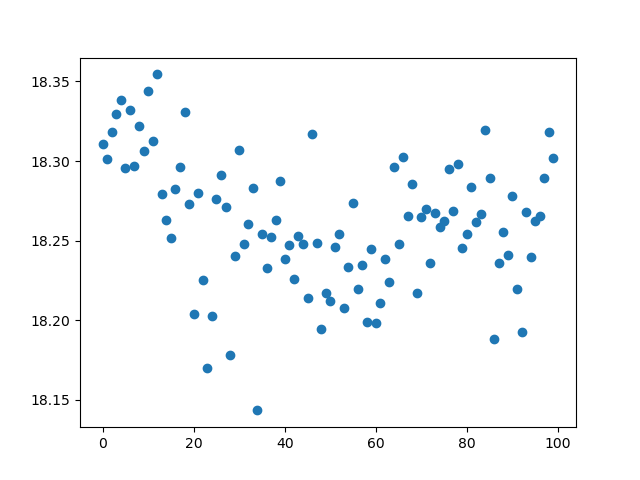

In [22]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(np.arange(len(lin_mag)), lin_mag)

# Qubit Spectroscopy

In [44]:
from CL_multimode_experiments.qubit_spectroscopy import *

# Configure LO

mxg1.set_output(state=False)
mxg1.set_frequency(7000000000)
mxg1.set_power(19)

data_path = "C:\\_Lib\\python\\Qick Old meas lab\\Test ZCU216 experiments\\data\\"
filename = 'qubit_spec'

In [45]:
path_to_parent = r'C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments' # this is where the parent folder lives (to get location of config file)
qspec = QubitSpectroscopyExperiment(path=path_to_parent,config_file='config_new.json')
qspec.cfg.expt={"start":4240, "step": .1, "expts": 400, "reps": 6000, "length": 30, "gain":4800}

C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.660099077928, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.660099077928, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.440389397353, 'f_ef': 4096.949181331015, 'pulses': {'pi_ge': {'gain': 2400, 'sigma': 0.2303}, 'pi2_ge': {'gain': 2400, 'sigma': 0.1152}}}}}, 'aliases': {'soc': 'myqick'}, 'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.236037836558, 'f_ef': 4100.0, 'pulses': {'pi

In [46]:
mxg1.set_output(state=True)
qspec.acquire(data_path=data_path, filename=filename, progress=True)
mxg1.set_output(state=False)

<Pyro4.core.Proxy at 0x223ad027910; connected IPv4; for PYRO:obj_23d01ef1d93a4e6881d424ba9d54e416@192.168.0.131:42493> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.660099077928, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs


  0%|          | 0/2400000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [32]:
result_dict['avgq']

<HDF5 dataset "avgq": shape (1, 400), type "<f8">

<IPython.core.display.Javascript object>


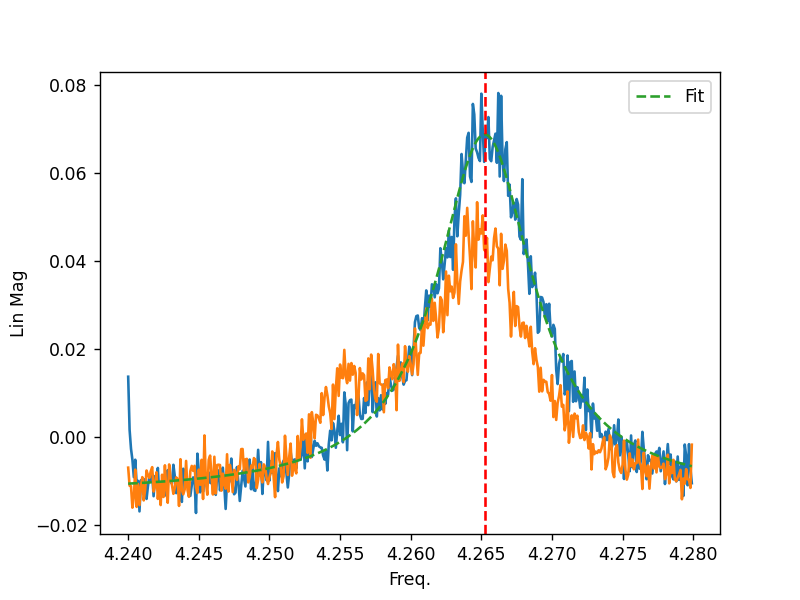

Qubit Frequency: 4.265236037836558
Qubit linewidth: 4.185188613595069 MHz
t_pi (expected)=  84.47728961242014


In [51]:
result_dict = h5py.File('C:\\_Lib\\python\\Qick Old meas lab\\Test ZCU216 experiments\\data\\00008_qubit_spec.h5', 'r')
freq = result_dict['freq'][0]/1e3
lin_mag = np.sqrt(result_dict['avgq'][0]**2 + result_dict['avgi'][0]**2)
# log_mag = np.array(file['mags'])[0]
# phase = np.array(file['phases'])[0]
# read_power = np.array(file['read_power'])[0]

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(freq, lin_mag,'bo')
I,Q = result_dict['avgi'][0],result_dict['avgq'][0]

I = I-np.median(I)
Q = Q-np.median(Q)

ax.plot(freq,I )
ax.plot(freq,Q)

p = fitlor(freq, I)
ax.plot(freq, lorfunc(p, freq), linestyle='--', label="Fit")

resonator_freq = p[2]
ax.axvline(resonator_freq, linestyle='--', c='r')
print("Qubit Frequency:", p[2])
print("Qubit linewidth:", p[3]*1e3,"MHz")
print ("t_pi (expected)= ",1/p[3]/2/np.sqrt(2))

   
ax.set_ylabel('Lin Mag')
ax.set_xlabel('Freq.')
ax.legend()



In [44]:
lorfunc?

# Length Rabi

In [3]:
from CL_multimode_experiments.length_rabi import *


In [4]:
lenrabi = LengthRabiExperiment(path=path_to_parent,config_file='config_new.json')
lenrabi.cfg.expt={
       "start": .006,  # in mic sec
       "step": .002, 
       "expts": 200, 
       "reps": 6000,
       "gain": 4800,
        "pulse_type": "gauss",
       "length_placeholder": 4}

NameError: name 'path_to_parent' is not defined

In [ ]:
mxg1.set_output(state=True)
result_lenrabi = lenrabi.acquire(progress=True)
mxg1.set_output(state=False)

In [78]:
from CL_multimode_experiments import PostExperimentAnalysis as pea

C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\CL_multimode_experiments\PostExperimentAnalysis.py:631: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ii is 0:
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\CL_multimode_experiments\PostExperimentAnalysis.py:661: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ii is 0:
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\CL_multimode_experiments\PostExperimentAnalysis.py:730: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if ii is 0:
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\CL_multimode_experiments\PostExperimentAnalysis.py:756: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ax.plot(t, P[i], 'bo-', label='ge_pi = ' + str(i is 0))
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\CL_multimode_experiments\PostExperimentAnalysis.py:1160: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ax.plot(t, P[i], 'bo-', label='ge_pi = ' + str(i is 0))


In [80]:
test = pea.PostExperiment()

TypeError: __init__() missing 6 required positional arguments: 'quantum_device_cfg', 'experiment_cfg', 'hardware_cfg', 'experiment_name', 'I', and 'Q'

In [31]:
avgq = [result_lenrabi['avgq'][i][0][0] for i in np.arange(len(result_lenrabi['avgq']))]
avgi = [result_lenrabi['avgi'][i][0][0] for i in np.arange(len(result_lenrabi['avgq']))]
P = avgi
time = result_lenrabi['xpts'][0]
t = time

In [103]:
result_lenrabi.keys()

dict_keys(['xpts', 'avgi', 'avgq', 'amps', 'phases'])

In [119]:
%matplotlib inline

<IPython.core.display.Javascript object>


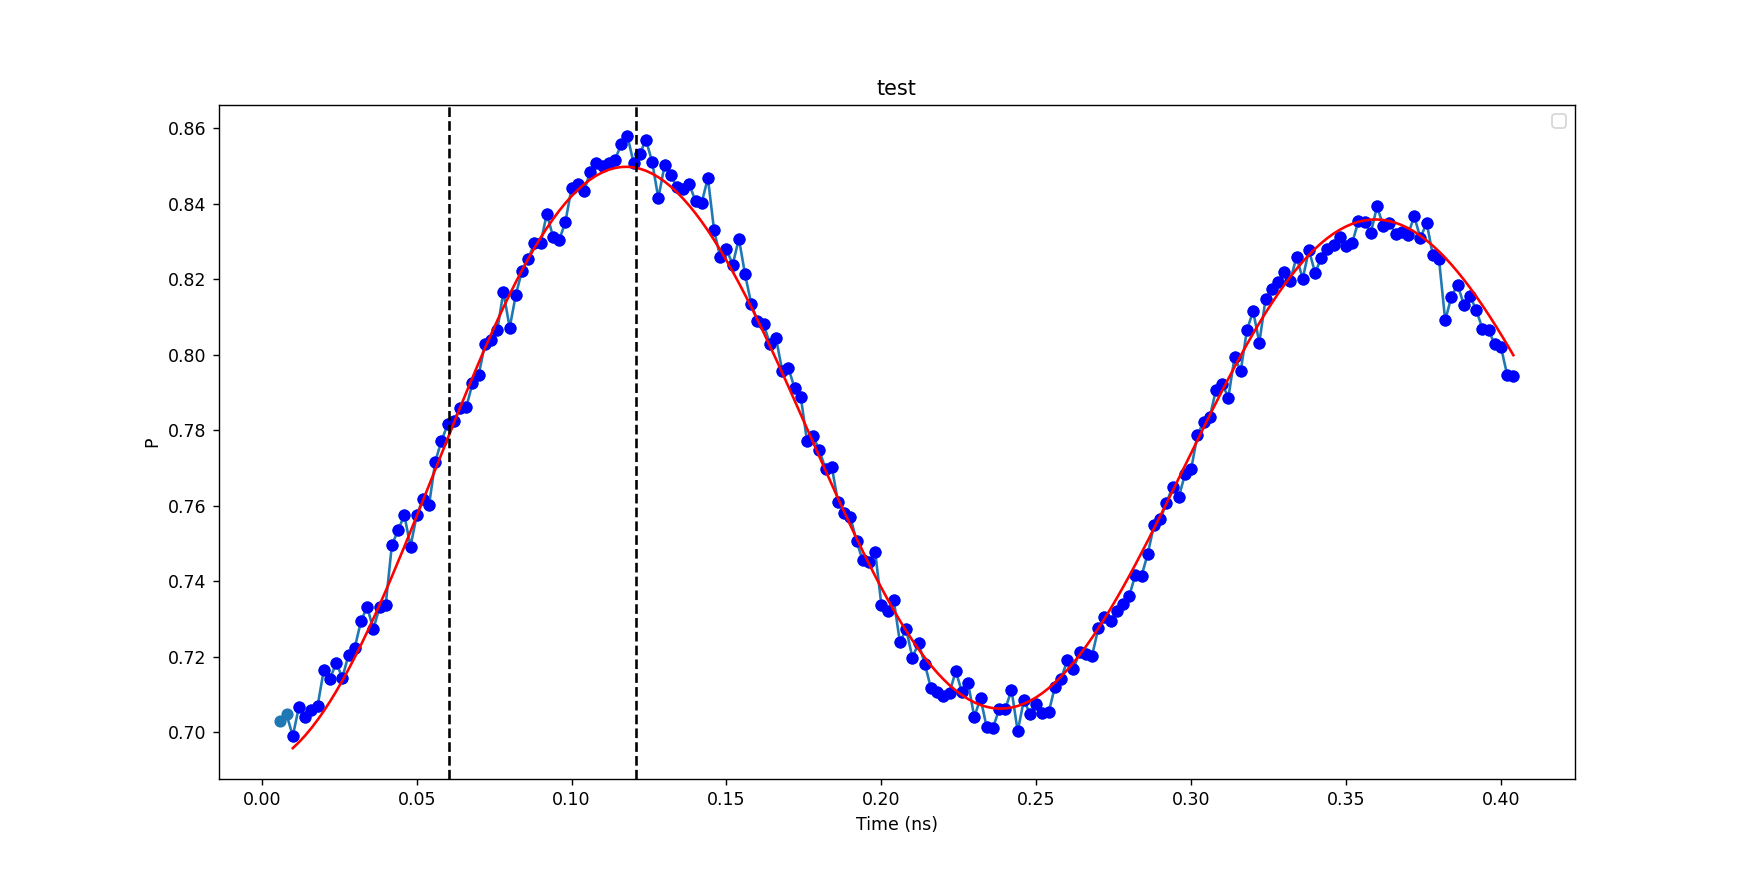

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Half pi length = 0.060474320465281305 ns
pi length = 0.12094864093056261 ns


In [32]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, title='test')
ax.plot(t, P, 'o-')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('P')
ax.legend()
p = fitdecaysin(t[2:], np.array(P)[2:], showfit=True)
t_pi = 1 / (2 * p[1])
t_half_pi = 1 / (4 * p[1])

ax.axvline(t_pi, color='k', linestyle='dashed')
ax.axvline(t_half_pi, color='k', linestyle='dashed')

plt.show()

print("Half pi length =", t_half_pi, "ns")
print("pi length =", t_pi, "ns")

<IPython.core.display.Javascript object>


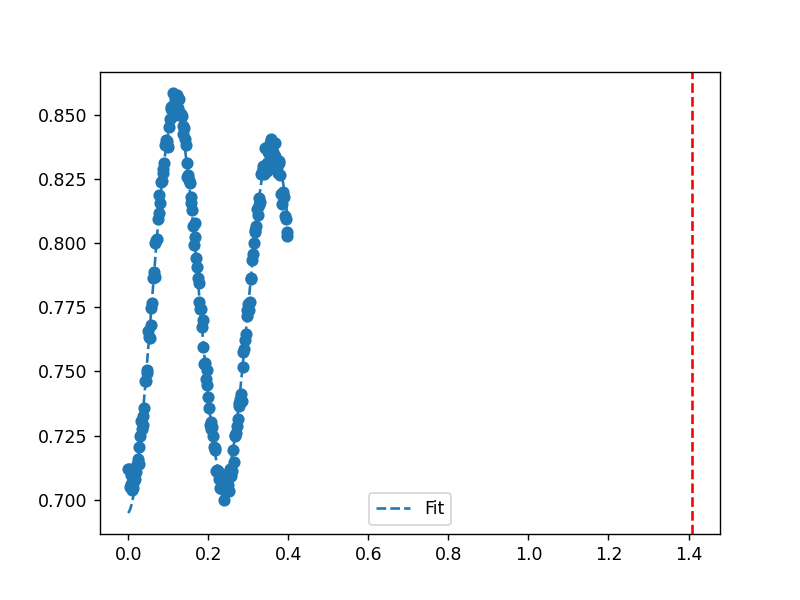

T2: 1.4082015303979736
Pi-pulse time: 0.24170543677058637


In [99]:
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.scatter(result_lenrabi['xpts'][0], avgq)
ax.scatter(time, avgi)

p = fitdecaysin(time, np.array(avgi))
ax.plot(time, decaysin(p, time), linestyle='--', label="Fit")

t2 = p[3]
pi_pulse_time = 1/p[1]
ax.axvline(t2, linestyle='--', c='r')
print("T2:", t2)
print("Pi-pulse time:", pi_pulse_time)

ax.legend()

In [ ]:
result_dict = h5py.File('C:\\_Lib\\python\\Qick Old meas lab\\Test ZCU216 experiments\\data\\00008_qubit_spec.h5', 'r')
freq = result_dict['freq'][0]/1e3
lin_mag = np.sqrt(result_dict['avgq'][0]**2 + result_dict['avgi'][0]**2)
# log_mag = np.array(file['mags'])[0]
# phase = np.array(file['phases'])[0]
# read_power = np.array(file['read_power'])[0]

fig = plt.figure()
ax = fig.add_subplot(111)
# ax.plot(freq, lin_mag,'bo')
I,Q = result_dict['avgi'][0],result_dict['avgq'][0]

I = I-np.median(I)
Q = Q-np.median(Q)

ax.plot(freq,I )
ax.plot(freq,Q)

p = fitlor(freq, I)
ax.plot(freq, lorfunc(p, freq), linestyle='--', label="Fit")

resonator_freq = p[2]
ax.axvline(resonator_freq, linestyle='--', c='r')
print("Qubit Frequency:", p[2])
print("Qubit linewidth:", p[3]*1e3,"MHz")
print ("t_pi (expected)= ",1/p[3]/2/np.sqrt(2))

   
ax.set_ylabel('Lin Mag')
ax.set_xlabel('Freq.')
ax.legend()



# Amplitude Rabi

In [87]:
from CL_multimode_experiments.amplitude_rabi import *

In [146]:
amprabi = AmplitudeRabiExperiment(path=path_to_parent,config_file='config_new.json')
amprabi.cfg.expt = {"start":1000,"step": 50, "expts":500, "reps": 8000,"rounds":10, "sigma_test": .28}

C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'adc_trig_offset': 60, 'relax_delay': 50}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.236037836558, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': {'gain': 4800, 'sigma': 0.06}}}}}, 'aliases': {'soc': 'myqick'}} test2


In [147]:
result_dict = amprabi.acquire(progress=True)

1000


  0%|          | 0/10 [00:00<?, ?it/s]

In [148]:
amp = result_dict['xpts']
avgq = result_dict['avgq'][0][0]
avgi = result_dict['avgi'][0][0]

<IPython.core.display.Javascript object>


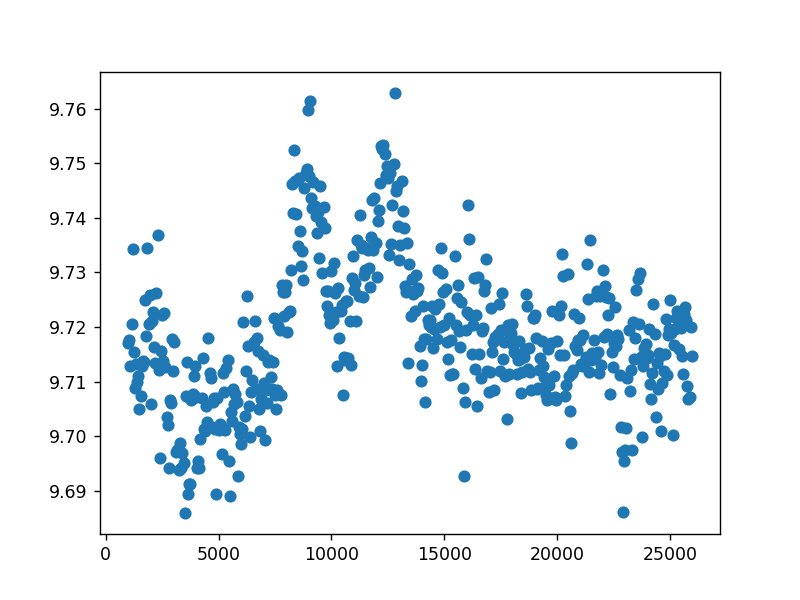

In [149]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(amp, avgq)
# ax.scatter(amp, avgi)

# T1

In [7]:
from CL_multimode_experiments.t1 import *

In [8]:
t1 = T1Experiment(path=path_to_parent,config_file='config_new.json')
t1.cfg.expt =  {"start":0, "step": 1, "expts":100, "reps": 1000, "rounds": 1}

C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4269.467892875422, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': {'gain': 4800, 'sigma': 0.06}}}}}, 'aliases': {'soc': 'myqick'}, 'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.236037836558, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': 

In [9]:
mxg1.set_output(state=True)
result_dict = t1.acquire(progress=True)
mxg1.set_output(state=False)

  0%|          | 0/100000 [00:00<?, ?it/s]

In [54]:
result_dict['xpts']

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
       11. , 11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. ,
       16.5, 17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5,
       22. , 22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. ,
       27.5, 28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5,
       33. , 33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       38.5, 39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5,
       44. , 44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. ,
       49.5])

In [55]:
avgq = result_dict['avgq'][0][0]
avgi = result_dict['avgi'][0][0]
P = avgi
t = result_dict['xpts']


In [56]:
%matplotlib inline

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


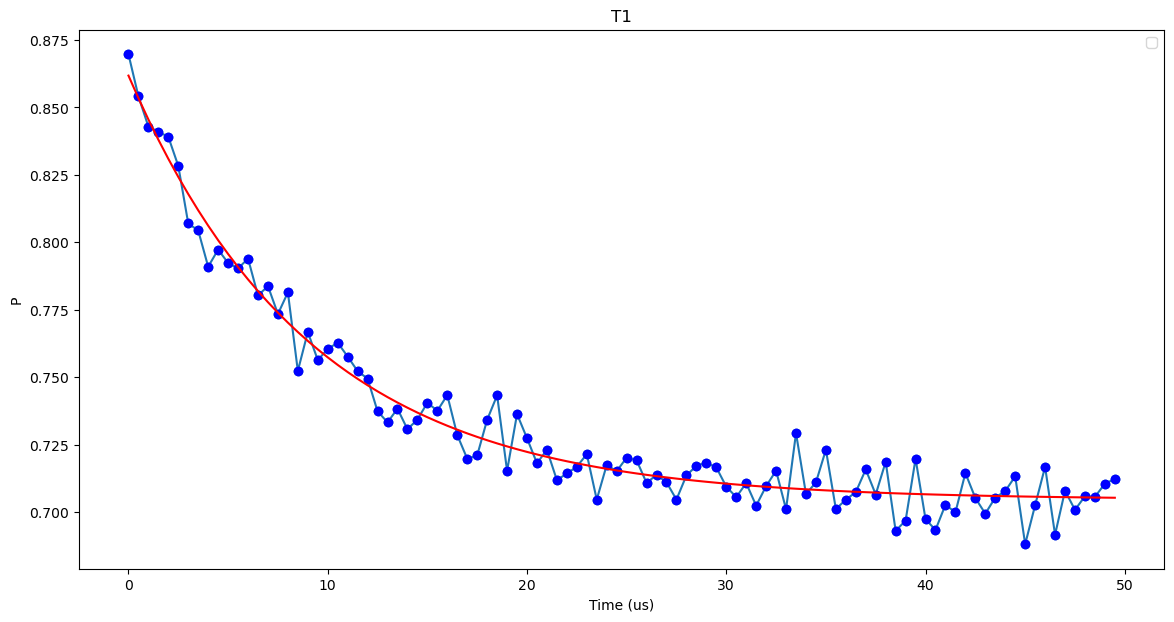

T1 = 9.158301765980648 us


In [57]:



fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111, title='T1')
ax.plot(t, P, 'o-')
ax.set_xlabel('Time (us)')
ax.set_ylabel('P')
ax.legend()
p = fitexp(t, P, showfit=True)
plt.show()



print("T1 =", p[3], "us")

# Ramsey

In [4]:
from CL_multimode_experiments.ramsey import *

In [5]:
ramsey_freq = 1
step = 0
phase_step = 360
path_to_parent = r'C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments'
ramsey = RamseyExperiment(path=path_to_parent,config_file='config_new.json')
ramsey.cfg.expt = {"start":0.0, "step": 0.002, "expts":500, "reps": 8000, "rounds": 1, "phase_step": 360}


C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4269.467892875422, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': {'gain': 4800, 'sigma': 0.06}}}}}, 'aliases': {'soc': 'myqick'}, 'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.236037836558, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': 

In [6]:
ramsey_freq = 5
step = 0.002
phase_step = 360*step*ramsey_freq
path_to_parent = r'C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments'
ramsey = RamseyExperiment(path=path_to_parent,config_file='config_new.json')
ramsey.cfg.expt = {"start":0.0, "step": step, "expts":200, "reps": 8000, "rounds": 1, "phase_step": phase_step}


C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4269.467892875422, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': {'gain': 4800, 'sigma': 0.06}}}}}, 'aliases': {'soc': 'myqick'}, 'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.236037836558, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': 

In [7]:
mxg1.set_output(state=True)
result_dict = ramsey.acquire(progress=True)
mxg1.set_output(state=False)

<Pyro4.core.Proxy at 0x1fca9f26e20; connected IPv4; for PYRO:obj_15f610a9061f4322918d261871020652@192.168.0.131:38143> test0


  0%|          | 0/1600000 [00:00<?, ?it/s]

In [7]:
avgq = result_dict['avgq'][0][0]
avgi = result_dict['avgi'][0][0]
P = avgi
t = result_dict['xpts']

In [15]:
%matplotlib inline

In [58]:
4268.521520870285-4268.994706872853

-0.4731860025685819

In [59]:
4268.521520870285+2*0.4731860025685819

4269.467892875422

<IPython.core.display.Javascript object>


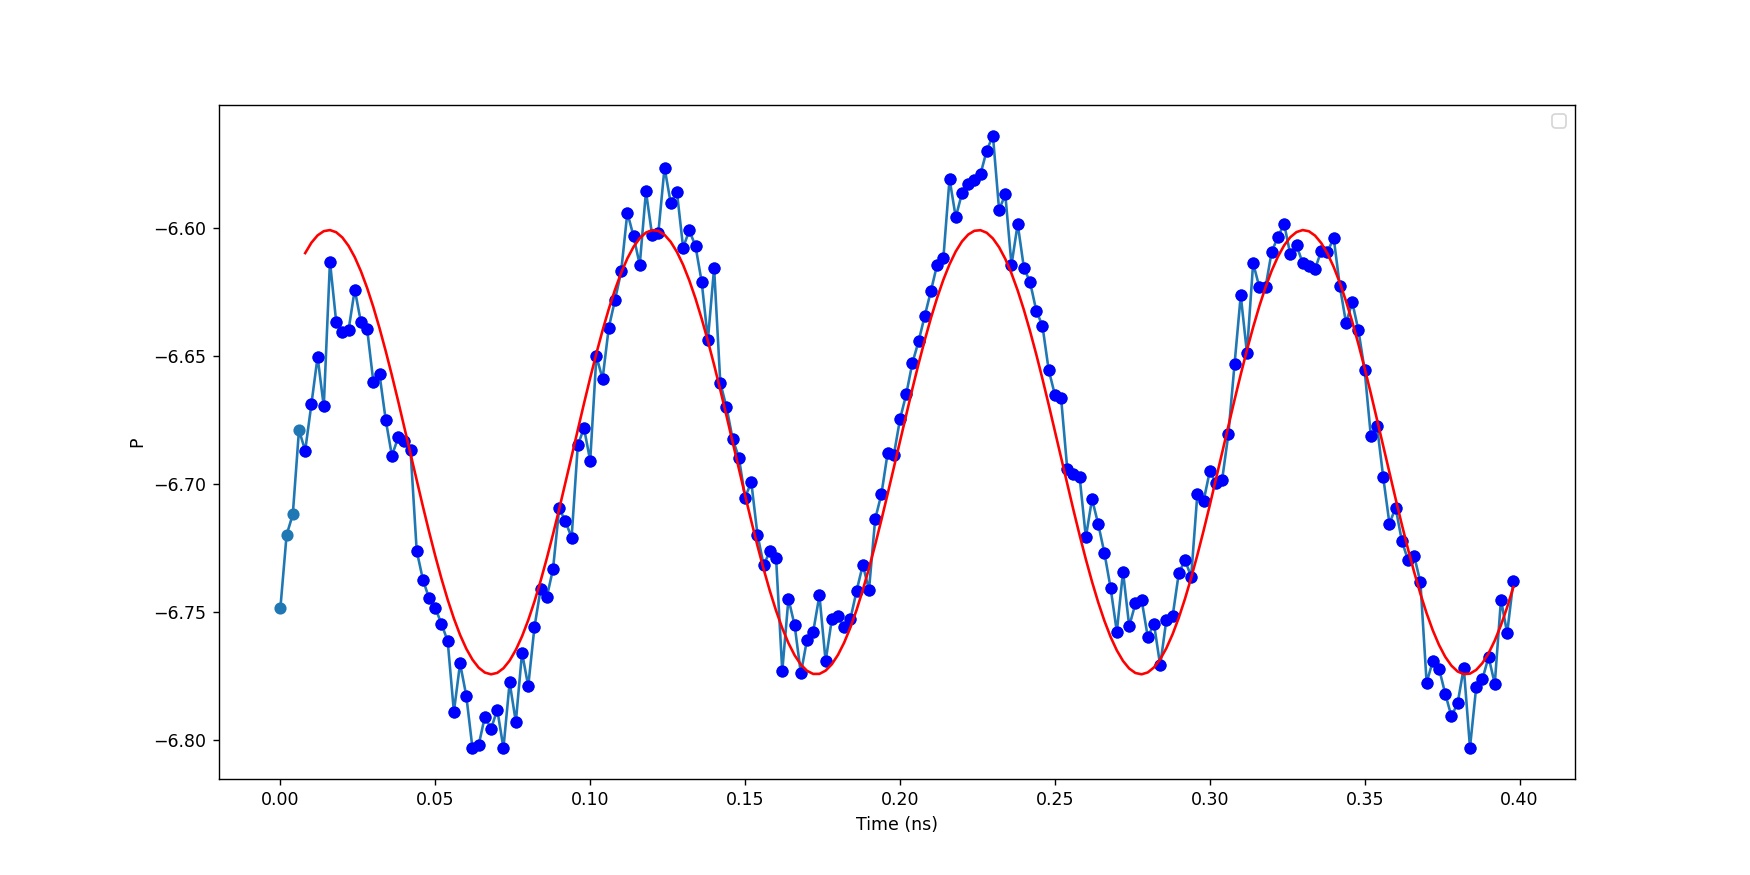

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Osc freq 9.536512211803945
Original qubit frequency choice = 4268.994706872853 MHz
Offset freq = -4.536512211803945 MHz
Suggested qubit frequency choice = 4264.45819466105 MHz
T2* = 3096349.817449725 us


In [8]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(t, P, 'o-')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('P')
ax.legend()
p = fitdecaysin(t[4:], P[4:], showfit=True)
plt.show()

print ("Osc freq", p[1])

offset = ramsey_freq - p[1]
nu_q = 4268.994706872853
nu_q_new = nu_q + offset

print("Original qubit frequency choice =", nu_q, "MHz")
print("Offset freq =", offset, "MHz")
print("Suggested qubit frequency choice =", nu_q_new, "MHz")
print("T2* =", p[3], "us")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


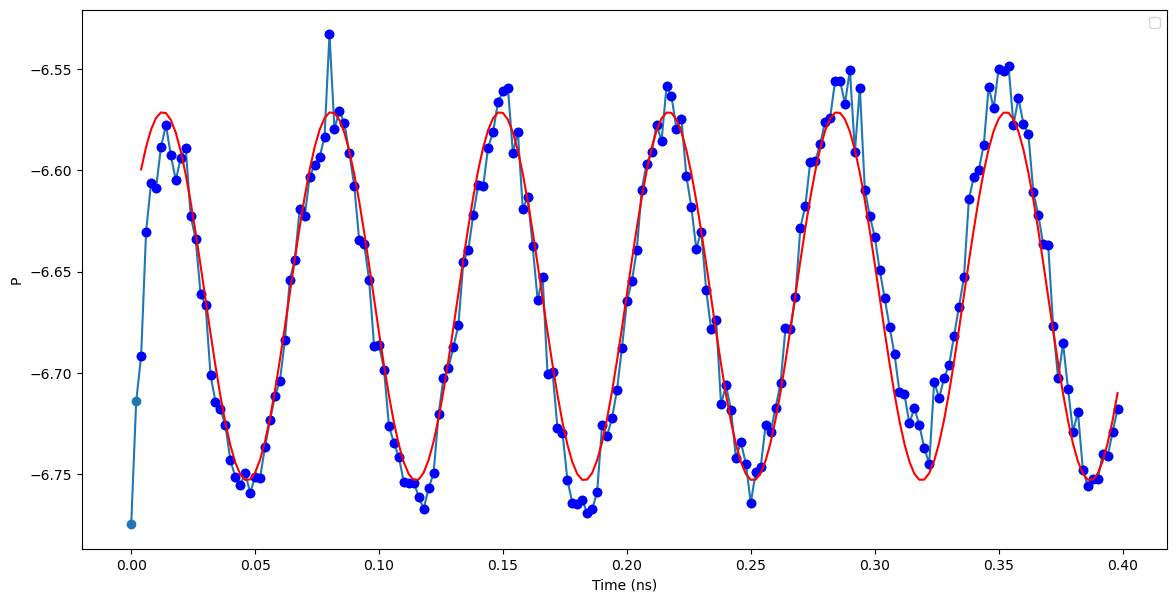

Osc freq 14.698466599349423
Original qubit frequency choice = 4268.994706872853 MHz
Offset freq = -4.698466599349423 MHz
Suggested qubit frequency choice = 4264.296240273504 MHz
T2* = 1000938.5083794752 us


In [11]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(111)
ax.plot(t, P, 'o-')
ax.set_xlabel('Time (ns)')
ax.set_ylabel('P')
ax.legend()
p = fitdecaysin(t[2:], P[2:], showfit=True)
plt.show()

print ("Osc freq", p[1])

offset = ramsey_freq - p[1]
nu_q = 4268.994706872853
nu_q_new = nu_q + offset

print("Original qubit frequency choice =", nu_q, "MHz")
print("Offset freq =", offset, "MHz")
print("Suggested qubit frequency choice =", nu_q_new, "MHz")
print("T2* =", p[3], "us")


In [68]:
print(p[1])

14.678428807434116


# EF Qubit Spectroscopy

In [149]:
from CL_multimode_experiments.pulseprobe_ef_spectroscopy import *

In [156]:
path_to_parent = r'C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments'
ef_qubit = PulseProbeEFSpectroscopyExperiment(path=path_to_parent,config_file='config_new.json')
ef_qubit.cfg.expt={"start":4096, "step": .01, "expts": 200, "reps": 6000, "length": 90, "gain":26000}

C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 5000, 'freq': 277.8, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 277.8, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4269.467892875422, 'f_ef': 4096.948831649639, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': {'gain': 4800, 'sigma': 0.06}}}}}, 'aliases': {'soc': 'myqick'}, 'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.236037836558, 'f_ef': 4100.0, 'pulses': {'pi_ge': {'gain': 4800, 'sigm

In [157]:
mxg1.set_output(state=True)
result_dict2 = ef_qubit.acquire(progress=True)
mxg1.set_output(state=False)

OrderedDict([(0, {'freq': 277.8, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 277.8, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs


  0%|          | 0/1200000 [00:00<?, ?it/s]

In [152]:
freq_pts = result_dict['xpts']
avgq = result_dict['avgq'][0][0]
avgi = result_dict['avgi'][0][0]

In [13]:
%matplotlib inline

<IPython.core.display.Javascript object>


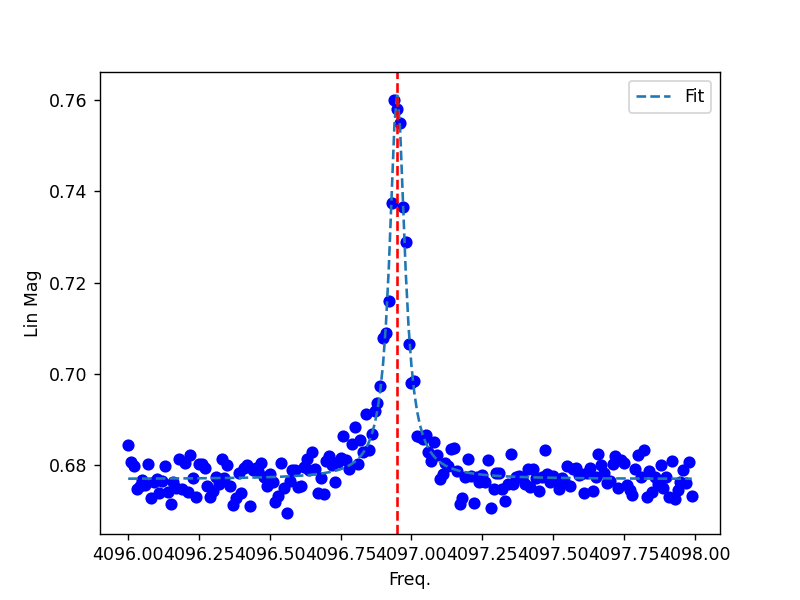

Qubit EF Frequency: 4096.94970967365
t_pi (expected)=  10.887625785001841


In [162]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq_pts, avgq,'bo')

p = fitlor(freq_pts, avgq)
ax.plot(freq_pts, lorfunc(p, freq_pts), linestyle='--', label="Fit")

qubit_ef_freq = p[2]
ax.axvline(qubit_ef_freq, linestyle='--', c='r')
print("Qubit EF Frequency:", p[2])
print ("t_pi (expected)= ",1/p[3]/2/np.sqrt(2))

ax.set_ylabel('Lin Mag')
ax.set_xlabel('Freq.')
ax.legend()

# ax.scatter(freq_pts, avgi)

In [158]:
freq_pts2 = result_dict2['xpts']
avgq2 = result_dict2['avgq'][0][0]
avgi2 = result_dict2['avgi'][0][0]

<IPython.core.display.Javascript object>


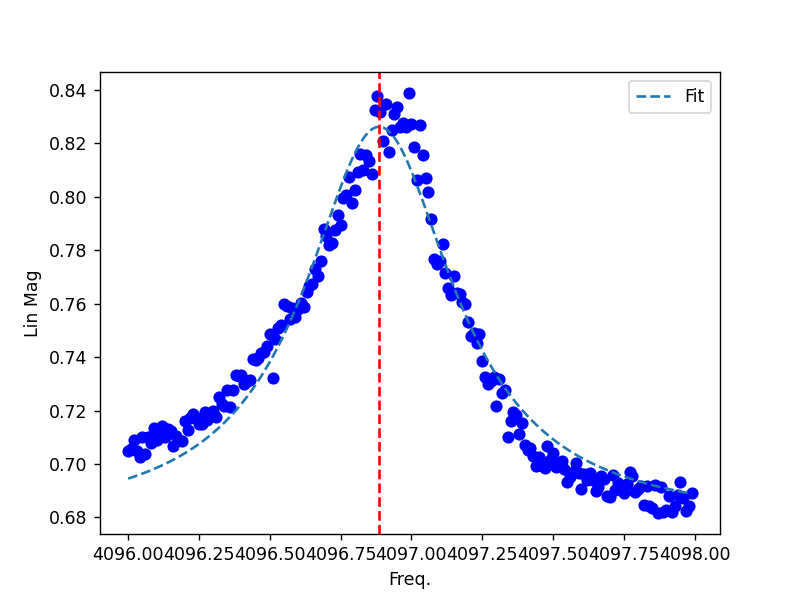

Qubit EF Frequency: 4096.886122259184
t_pi (expected)=  1.100024194034001


In [163]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq_pts2, avgq2,'bo')

p = fitlor(freq_pts2, avgq2)
ax.plot(freq_pts2, lorfunc(p, freq_pts2), linestyle='--', label="Fit")

qubit_ef_freq = p[2]
ax.axvline(qubit_ef_freq, linestyle='--', c='r')
print("Qubit EF Frequency:", p[2])
print ("t_pi (expected)= ",1/p[3]/2/np.sqrt(2))

ax.set_ylabel('Lin Mag')
ax.set_xlabel('Freq.')
ax.legend()

# ax.scatter(freq_pts, avgi)

# Length Rabi EF

In [6]:
from CL_multimode_experiments.length_rabi_ef import *

In [7]:
path_to_parent = r'C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments'
lenrabi_ef = LengthRabiEFExperiment(path=path_to_parent,config_file='config_new.json')
lenrabi_ef.cfg.expt={
       "start": .006,  # in mic sec
       "step": .2, 
       "expts": 300, 
       "reps": 6000,
       "gain": 26000,
        "pulse_type": "const",
       "length_placeholder": 4}

C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 1000, 'freq': 186.941860258892, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 186.941860258892, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.424523771228, 'f_ef': 4101.630947496188, 'pulses': {'pi_ge': {'gain': 2400, 'sigma': 0.2393}, 'pi2_ge': {'gain': 2400, 'sigma': 0.11965}}}}}, 'aliases': {'soc': 'myqick'}} test2


In [23]:
mxg1.set_output(state=True)
result_dict = lenrabi_ef.acquire(progress=True)
mxg1.set_output(state=False)

  0%|          | 0/300 [00:00<?, ?it/s]

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4})]) test_rochs
<Pyro4.core.Proxy at 0x223aa2994f0; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3
OrderedDict([(0, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', 'gen_ch': 4}), (1, {'freq': 282.728267532144, 'length': 2150, 'sel': 'product', '

In [174]:
result_dict.keys()

dict_keys(['xpts', 'avgi', 'avgq', 'amps', 'phases'])

In [39]:
freq_pts = result_dict['xpts'][0]
avgq = np.array([result_dict['avgq'][i][0][0] for i in np.arange(len(result_dict['xpts']))])
avgi = np.array([result_dict['avgi'][i][0][0] for i in np.arange(len(result_dict['xpts']))])
mag = np.sqrt(avgq**2 + avgi**2)

In [25]:
%matplotlib notebook

<IPython.core.display.Javascript object>


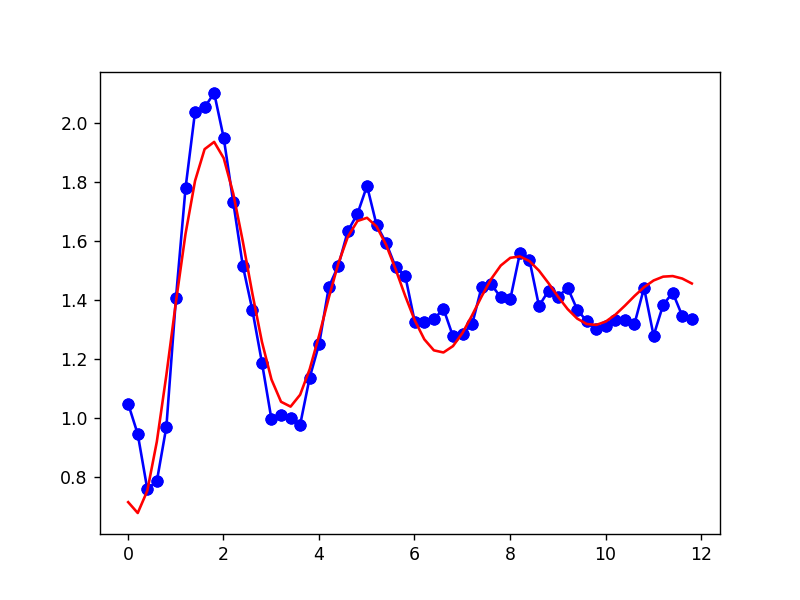

Pi-pulse time: 1.5960772488013446


In [43]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq_pts[:60], np.sqrt(avgq**2 + avgi**2)[:60],'bo-')

p = fitdecaysin(freq_pts[:60], mag[:60], showfit=True)
t_pi = 1 / (2 * p[1])
t_half_pi = 1 / (4 * p[1])

print("Pi-pulse time:", t_pi)

# p = fitlor(freq_pts, avgq)
# ax.plot(freq_pts, lorfunc(p, freq_pts), linestyle='--', label="Fit")

# qubit_ef_freq = p[2]
# ax.axvline(qubit_ef_freq, linestyle='--', c='r')
# print("Qubit EF Frequency:", p[2])

# ax.set_ylabel('Lin Mag')
# ax.set_xlabel('Freq.')
# ax.legend()

# ax.scatter(freq_pts, avgi)

# Qubit Temperature

In [3]:
from CL_multimode_experiments.qubit_temperature import *

In [11]:
path_to_parent = r'C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments'
qubit_temp = QubitTemperatureExperiment(path=path_to_parent,config_file='config_new.json')
qubit_temp.cfg.expt={
       "start": 5000,  # in mic sec
       "step": 50, 
       "expts": 100, 
       "reps": 6000,
       "sigma_test": 4,
       "ge_pi_after": False,
       "rounds_without_pi_first":False}  # "rounds" key

C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments test0
config_new.json test
C:\_Lib\python\Qick Old meas lab\Test ZCU216 experiments\config_new.json test1
{'device': {'soc': {'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 5000, 'freq': 277.8, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 277.8, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4269.467892875422, 'f_ef': 4096.948831649639, 'pulses': {'pi_ge': {'gain': 4800, 'sigma': 0.12}, 'pi2_ge': {'gain': 4800, 'sigma': 0.06}}}}}, 'aliases': {'soc': 'myqick'}, 'resonator': {'ch': 4, 'nyqist': 1, 'res_phase': 0, 'gain': 8000, 'freq': 282.661503113286, 'phase': 0}, 'readout': {'ch': [0], 'nyqist': 1, 'length': 5, 'readout_length': 5, 'adc_trig_offset': 60, 'relax_delay': 50, 'freq': 282.661503113286, 'phase': 0}, 'qubit': {'ch': 6, 'nyqist': 1, 'f_ge': 4265.236037836558, 'f_ef': 4100.0, 'pulses': {'pi_ge': {'gain': 4800, 'sigm

In [12]:
mxg1.set_output(state=True)
result_dict = qubit_temp.acquire(progress=True)
mxg1.set_output(state=False)

<Pyro4.core.Proxy at 0x223a9b2fe20; connected IPv4; for PYRO:obj_249079dc1c7e455190fc3eb3f6cac241@192.168.0.131:40365> tester1
True tester2
internal tester3


RuntimeError: AxisSignalGen: buffer length must be 65536 samples or less.